#### Transfer Learning using Pytorch

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting random seeds for reproducibility
torch.manual_seed(42)

In [3]:
df = pd.read_csv('fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


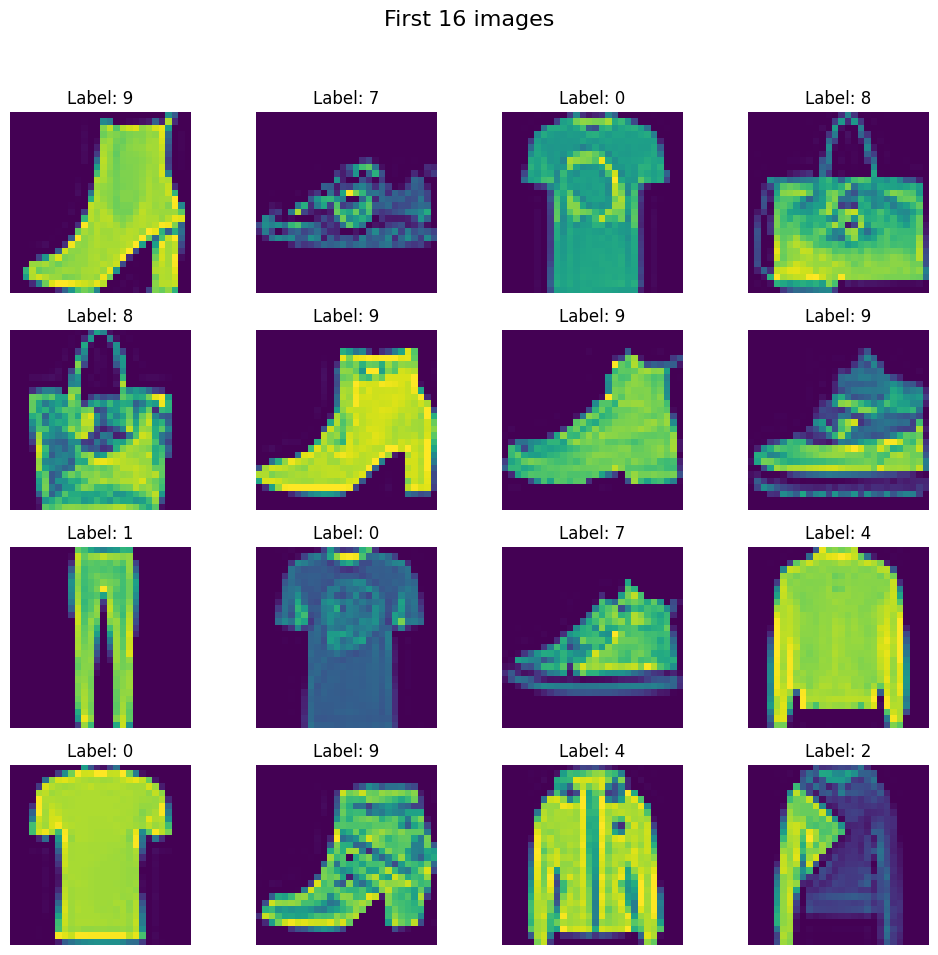

In [4]:
# creating a 4x4 grid of images
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 images", fontsize=16)

# plotting the first 16 images
for i, ax in enumerate(ax.flat): # iterating over the axes
  img = df.iloc[i, 1:].values.reshape(28, 28) # reshaping the image to 28x28
  ax.imshow(img) # plotting the image
  ax.axis('off') # removing the axis
  ax.set_title(f"Label: {df.iloc[i, 0]}") # setting the title

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # adjusting the layout
plt.show()

In [5]:
# train test split

X = df.iloc[:, 1:].values # features
y = df.iloc[:, 0].values # labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ..., 16,  0,  0]], dtype=int64)

In [7]:
# transformations that have to be done according to Pytorch documents:
# 1. Resize operation
# 2. Center crop
# 3. Tensor conversion
# 4. Normalization

# For all the above steps we will be using torchvision.transforms
from torchvision.transforms import transforms

custom_transform = transforms.Compose([ # creating a composition of transforms
  transforms.Resize(112), # resizing the image to 28x28 (step 1)
  # transforms.CenterCrop(224), # cropping the image to 224x224 (step 2)
  transforms.ToTensor(), # converting the image to tensor (step 3)
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizing the image (step 4)
])


In [8]:
from PIL import Image
import numpy as np

# creating a custom dataset class
class CustomDataset(Dataset): # inheriting from Dataset class

  # constructor
  def __init__(self, features, labels, transform): # passing the features and labels
    self.features = features # storing the features
    self.labels = labels # storing the labels
    self.transforms = transform # storing the transforms

  # length of the dataset
  def __len__(self):
    return len(self.features) # returning the length of the features
  
  # getting the item
  def __getitem__(self, index):

    # resizing the image 28x28
    image = self.features[index].reshape(28, 28) # reshaping the image to 28x28
  
    # changing data type to np.uint8
    image = image.astype(np.uint8) # changing the data type to np.uint8

    # converting greyscale image to rgb image
    image = np.stack([image]*3, axis= -1) # converting into 3 channels and from (C, H, W) tot (H, W, C)

    # converting array to PIL image
    image = Image.fromarray(image) # converting into PIL image

    # applying transforms
    image = self.transforms(image)

    # return
    return image, torch.tensor(self.labels[index], dtype= torch.long)

In [9]:
# creating a training dataset object
train_dataset = CustomDataset(X_train, y_train, transform=custom_transform) # passing the features and labels

In [10]:
# creating a test dataset object
test_dataset = CustomDataset(X_test, y_test, transform=custom_transform) # passing the features and labels

In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=False, num_workers=2)

In [12]:
# fetching the pretrained model VGG16

# import torchvision.models as models

# vgg16 = models.vgg16(pretrained= True)

In [13]:
# Load a smaller pretrained model for cpu (ResNet18 instead of VGG16)
import torchvision.models as models
from torchvision import models

device = torch.device("cpu")
model = models.resnet18(pretrained=True).to(device).half()

In [14]:
#device = torch.device("cpu")  # Force CPU usage
#vgg16.to(device)


In [15]:
# freezing the features extraction part
#for param in vgg16.features.parameters(): # iterating over the parameters
  #param.requires_grad = False # freezing the parameters

In [16]:
# Freeze feature extraction layers
for param in model.parameters():
    param.requires_grad = False

In [17]:
# replacing the classifier part with our own classifier
# Modify the classifier layer
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
).to(device).half()

In [18]:
learning_rate = 0.0001
epochs = 10

In [19]:
# loss function
loss_function = nn.CrossEntropyLoss() # for classification problems

# optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=0.01) # stochastic gradient descent

In [ ]:
# Training Loop
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Forward
        outputs = model(batch_features)
        loss = loss_function(outputs, batch_labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    print(f'Epoch: {epoch+1}, Loss: {total_epoch_loss / len(train_loader)}')

In [ ]:
# model evaluation
model.eval() # setting the model in evaluation mode

MyCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
# evaluation code
total = 0 # variable to store the total number of samples
correct = 0 # variable to store the total number of correct predictions

with torch.no_grad(): # disabling gradients
  for batch_features, batch_labels in test_loader: # iterating over the batches

    # forward pass
    outputs = vgg16(batch_features) # passing the features

    # prediction
    _, predicted = torch.max(outputs.data, 1) # getting the index of the maximum value

    # accuracy calculation
    total += len(batch_labels) # adding the number of samples to the total
    correct += (predicted == batch_labels).sum().item() # adding the number of correct predictions to the correct

print(f'Accuracy: {correct / total}')

Accuracy: 0.8625
